# IUM - Dokumentacja wstępna
Mikołaj Szawerda, Dawid Kaszyński

## Treść zadania
“Gdybyśmy tylko wiedzieli, kiedy użytkownik będzie chciał przesłuchać bieżący utwór w
całości, a kiedy go przewinie – moglibyśmy lepiej zorganizować nasz cache”

## Definicja problemu
Zadanie polega na stworzeniu rozwiązania, które na podstawie dostępnych danych(danych użytkowników, piosenek, autorów, logów sesji) udzieli odpowiedzi, czy użytkownik rozpoczynający odtworzenie danej piosenki przesłucha ją w całości, czy też ją przewinie.
Polecenie zawiera dodatkową informację, mówiącą o celu biznesowym rozwiązania - odpowiedź ma determinować organizację systemu cache.

## Definicja zadania modelowania
Przedstawiony problem jest zadaniem klasyfikacji binarnej. Dla cech pary użytkownik-piosenka należy przyporządkować oczekiwany rezultat interakcji - czy zajdzie zdarzenie przewinięcia.

## Kryteria sukcesu

### Biznesowe

Model umożliwi redukcję kosztów wynikających z przechowywania piosenek w cache'u w stosunku do sytuacji obecnej.

**Uzasadnienie**

Z dostępnych danych (zbiór track_storage.jsonl) wynika, że koszt przechowywania piosenek różni się w zależności od klasy cache'u i utworu. Wybranie odpowiecniej klasy w zależności od tego, czy utwór zostanie odsłuchany w całości może przyczyniść się do redukcji kosztów, ponieważ możliwe będzie
np. umieszczanie często przewijanych utworów w tańszym cache'u.

### Analityczne

Model będzie przewidywał przewinięcia piosenek z dokładnością wynoszącą conajmniej 80%.

**Uzasadnienie**

Możemy przyjąć, że model naiwny będzie miał dokładność bliską 50%. Każda wartość powyżej 50% ma szansę umożliwić optymalizację cache'u, ponieważ oznacza to, że
jest to model lepszy niż losowy, natomiast dokładność na poziomie 80% daje bezpieczny margines odróżniający model naiwny od modelu pożądanego.

# Analiza danych
Eksplorując dane oraz badając ich potencjał na rozwiązanie zadania biznesowego musimy uwzględnić kontekst w jakim model będzie wykorzystywany w celu prawidłowego zaprojektowania interfejsu modelu:
- Wyjściem modelu będzie klasyfikacja "tak" (piosenka zostanie przewinięta) lub "nie" (nie zostanie przewinięta).
- Aby dobrze zdefiniować parametry wejściowe modelu należy rozważyć w jakim kontekście biznesowym będzie on wykorzystywany - model będzie odpytywany przed lub w  trakcie uruchomienia danego utworu. Oznacza to, że będzie dostęp do następujących informacji:
    - Kontekst użytkownika: jego preferencje oraz skłonności
    - Kontekst piosenki: jej cechy (np. danceability, acousticness) oraz pośrednio dostęp do gatunków (dzięki informacji o wykonawcy oraz gatunkach w jakich on tworzy)
    - Kontekst obecnej sesji użytkownika - jej czas trwania, interakcje użytkownika z piosenkami (przewinięcia, polubienia) w ramach bieżącej sesji

Pierwsza iteracja modelu będzie zatem opierała się na przewidywaniu wydarzeń przewinięcia piosenki dla trójki (użytkownik, piosenka, sesja), gdzie każde z nich jest reprezentowane poprzez zbiór atrybutów i parametrów je opisujących.

In [170]:
import pandas as pd
import seaborn as sns
from pandas import Timedelta
import warnings
import itertools
from scipy.sparse import csr_matrix, vstack, hstack
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import TruncatedSVD

warnings.simplefilter(action='ignore', category=FutureWarning)
sns.set_theme()
import matplotlib.pyplot as plt
sns.set_theme(style="whitegrid")

In [167]:
sessions = pd.read_json("data/sessions.jsonl", lines=True)
artists = pd.read_json("data/artists.jsonl", lines=True)
tracks = pd.read_json("data/tracks.jsonl", lines=True)
track_storage = pd.read_json("data/track_storage.jsonl", lines=True)
users = pd.read_json("data/users.jsonl", lines=True)
genres = tracks.join(artists.set_index('id')['genres'], on='id_artist', rsuffix='_author').set_index('id')['genres']
all_genres = genres.explode().unique()

def genre_similarity(g1, g2):
    g1_words = set(g1.lower().split())
    g2_words = set(g2.lower().split())
    return len(g1_words.intersection(g2_words))/(len(g1_words.union(g2_words)))

def genres_similarity(genres1, genres2):
    simillarity = 0
    for g1, g2 in itertools.product(genres1, genres2):
        indicator = 2
        if g1 != g2:
            words_genre1 = set(g1.lower().split())
            words_genre2 = set(g2.lower().split())
            indicator = 1 if any(word in words_genre2 for word in words_genre1) else 0
        simillarity += indicator
    return simillarity

def extract_release_date(tdf: pd.DataFrame):
    def standardize_date(date):
        parts = date.split('-')
        if len(parts) == 1:  # Only year
            return f"{parts[0]}-01-01"
        elif len(parts) == 2:  # Year and month
            return f"{parts[0]}-{parts[1]}-01"
        return date
    
    def date_completeness(date):
        parts = len(date.split('-'))
        if parts == 1:
            return 'year'
        elif parts == 2:
            return 'year_month'
        return 'full_date'
    
    tdf['standardized_date'] = pd.to_datetime(tdf['release_date'].apply(standardize_date))
    tdf['release_year'] = tdf['standardized_date'].dt.year
    tdf['release_daymonth'] = tdf['standardized_date'].dt.dayofyear
    tdf['date_completeness'] = tdf['release_date'].apply(date_completeness)

    return tdf.drop(columns=['standardized_date'])

def show_basic_info(df: pd.DataFrame):
    print("# rows", len(df))
    print("Columns", df.columns.values)
    print("Missing values: ", df.columns[(df.isna().mean()>0) | (df.isnull().mean()>0) ])



def encode_track(track_genres):
    row_indices, col_indices, data = [], [], []
    for i, track_genre in enumerate(track_genres):
        for j, other_genre in enumerate(all_genres):
            similarity = genre_similarity(track_genre, other_genre)
            if similarity != 0:
                row_indices.append(i)
                col_indices.append(j)
                data.append(similarity)
    return csr_matrix(csr_matrix((data, (row_indices, col_indices)), shape=(len(track_genres), len(all_genres))).sum(axis=0))

    


# Analiza braków i czyszczenie danych

# rows 24491
Columns ['timestamp' 'user_id' 'track_id' 'event_type' 'session_id']
Missing values:  Index([], dtype='object')
# sessions 648
Timestamp range:  2023-01-02 02:48:05 - 2023-11-23 20:23:32.271000


Text(0.5, 1.0, 'Song played <= 10 times')

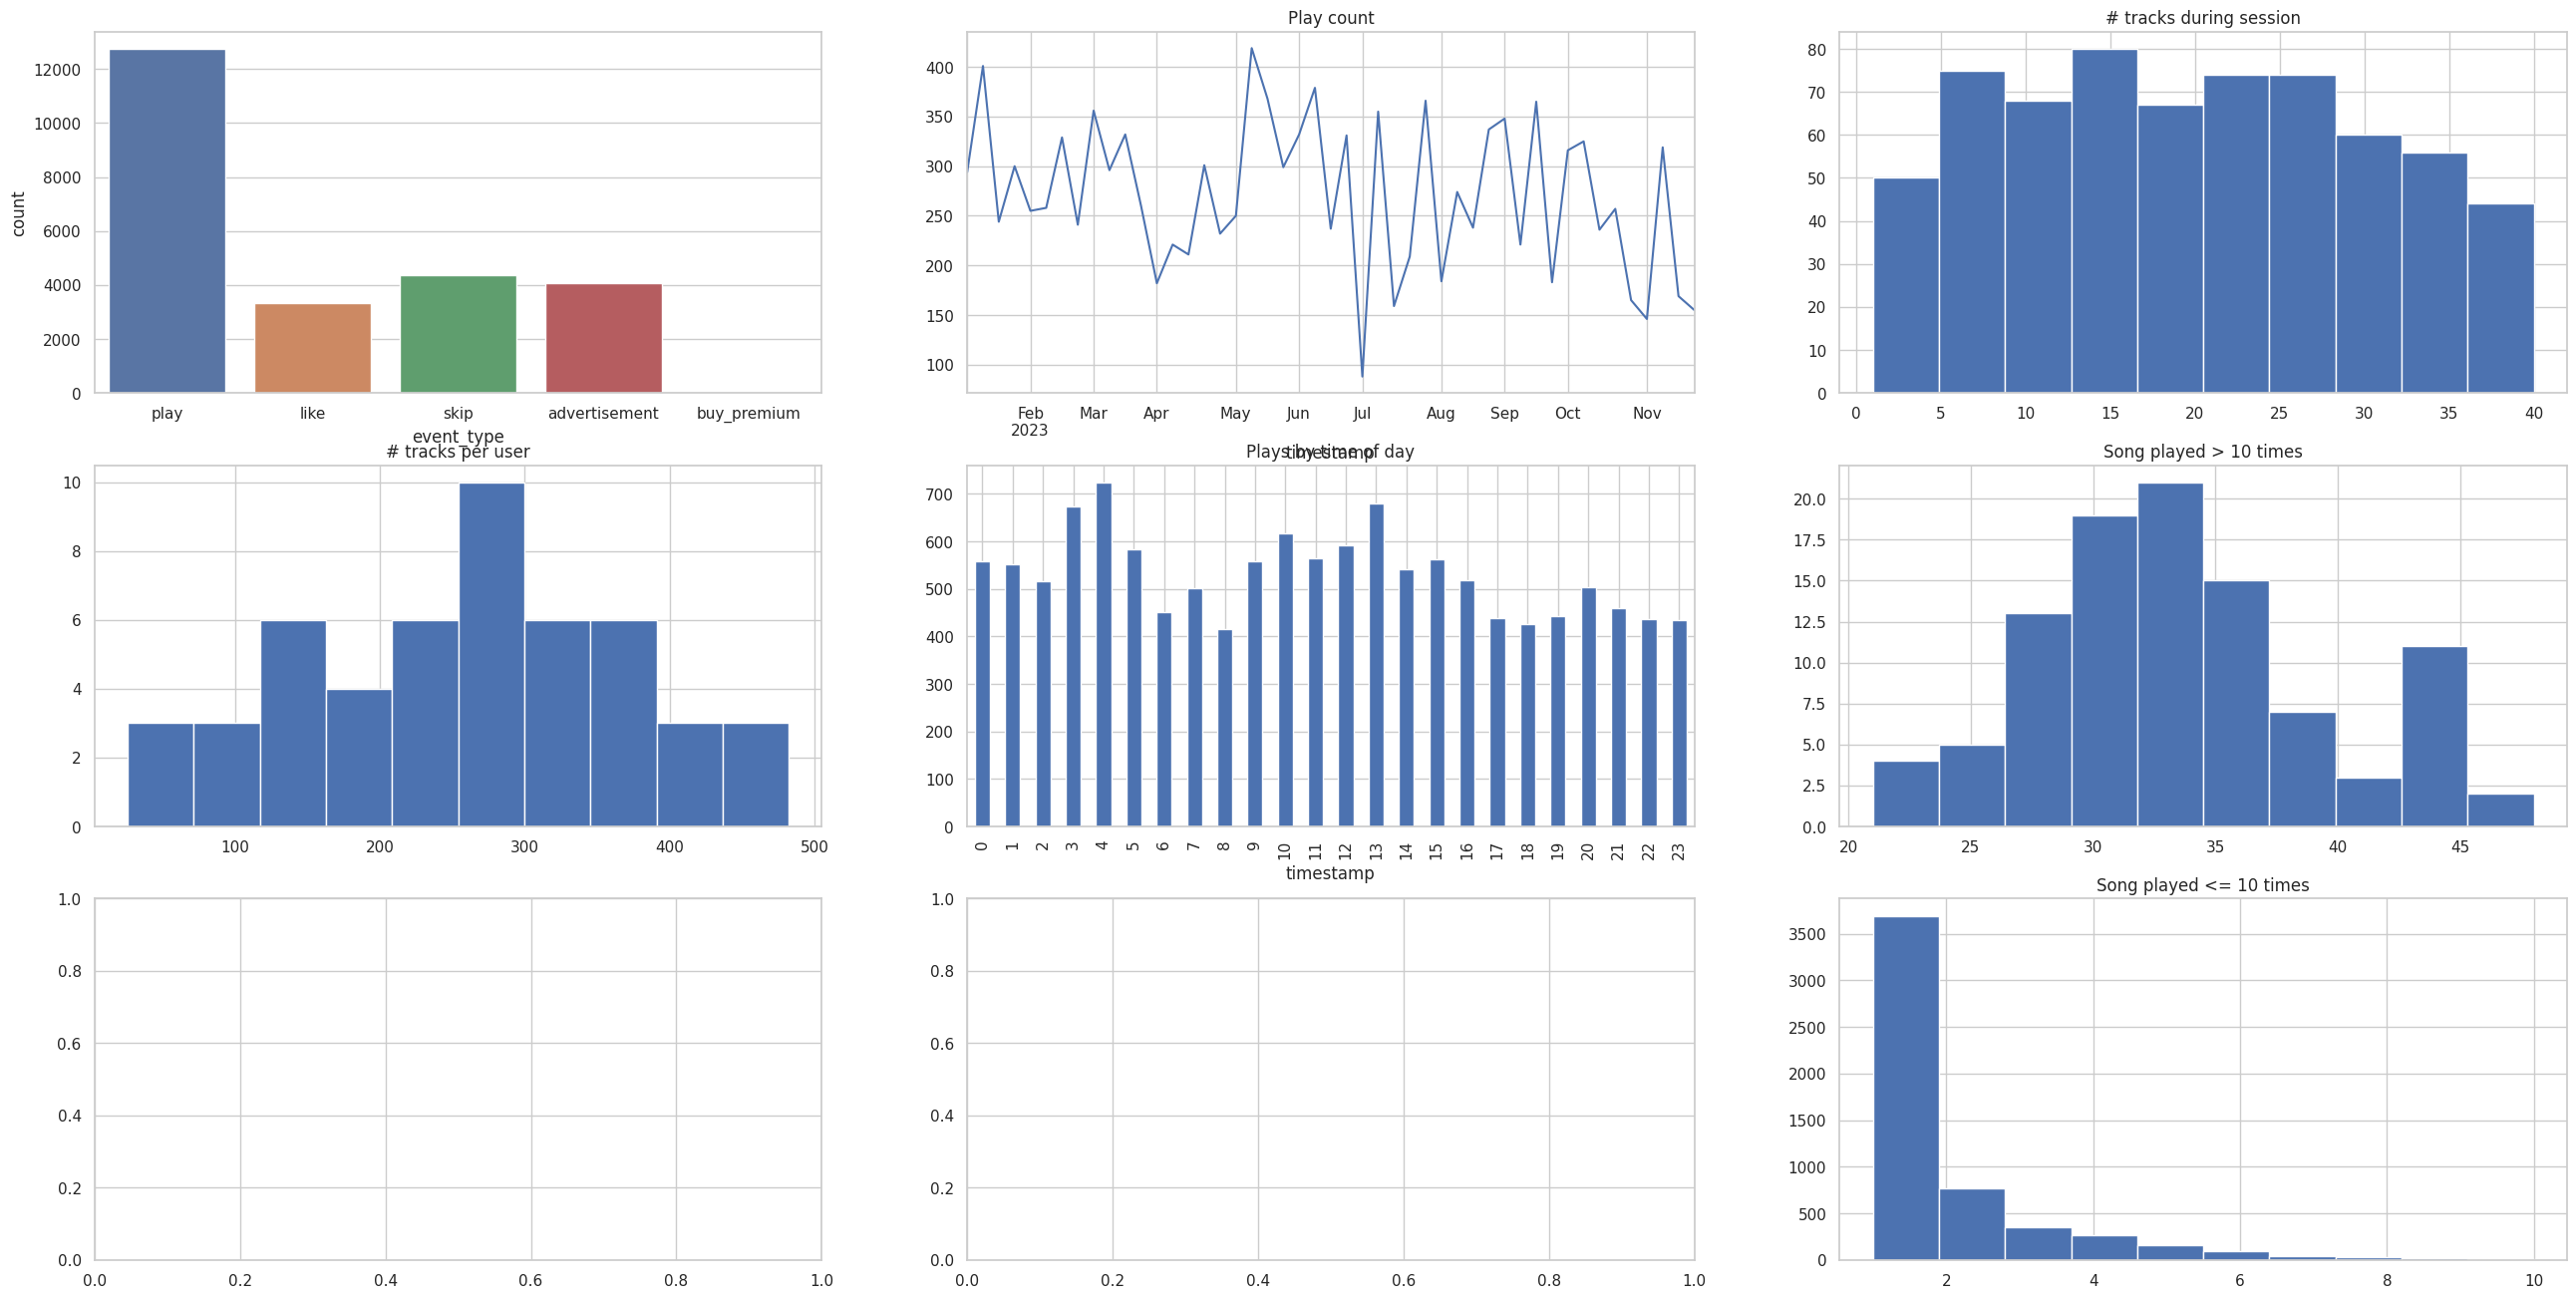

In [139]:

show_basic_info(sessions)
print("# sessions", len(sessions['session_id'].unique()))
print("Timestamp range: ", min(sessions['timestamp']), "-", max(sessions['timestamp']))

fig, axs = plt.subplots(3, 3, figsize=(32, 16))
sns.countplot(sessions, x='event_type', ax=axs[0, 0])
play_events = sessions[sessions['event_type']=='play']
play_events.set_index('timestamp')['track_id'].resample('W').count().plot(ax=axs[0, 1], title='Play count')
axs[0, 2].set_title('# tracks during session')
play_events.groupby('session_id')['track_id'].count().hist(ax=axs[0, 2])
axs[1, 0].set_title('# tracks per user')
play_events.groupby('user_id')['track_id'].count().hist(ax=axs[1, 0])
play_events.groupby(play_events['timestamp'].dt.hour)['timestamp'].count().plot(kind='bar', ax=axs[1,1], title="Plays by time of day")
play_events.groupby('track_id')['track_id'].count().where(lambda x: x>10).dropna().hist(ax=axs[1,2])
axs[1, 2].set_title('Song played > 10 times')

play_events.groupby('track_id')['track_id'].count().where(lambda x: x<=10).dropna().hist(ax=axs[2,2])
axs[2, 2].set_title('Song played <= 10 times')
play_events.groupby('track_id')['track_id'].count().where(lambda x: x<=10).dropna().hist(ax=axs[2,2])
axs[2, 2].set_title('Song played <= 10 times')

## Twórcy

# rows 10661
Columns ['id' 'name' 'genres']
Missing values:  Index([], dtype='object')
Unique artists:  6775


<Axes: xlabel='PC1', ylabel='PC2'>

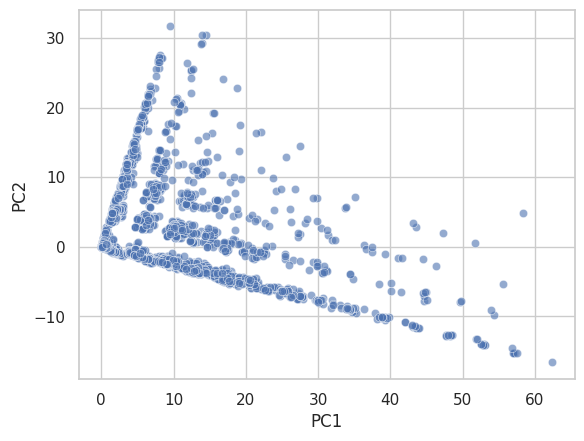

In [180]:
show_basic_info(artists)
unique_artists = artists.set_index('id')['genres'].map(lambda x: frozenset(x)).unique()
print("Unique artists: ", len(unique_artists))
svd = TruncatedSVD(n_components=2)
pca_df = pd.DataFrame(data=svd.fit_transform(vstack(vstack(encode_track(artist) for artist in unique_artists))), columns=['PC1', 'PC2'])
sns.scatterplot(pca_df, x='PC1', y='PC2', alpha=0.6)


## Ścieżki

# rows 21608
Columns ['id' 'name' 'popularity' 'duration_ms' 'explicit' 'id_artist'
 'release_date' 'danceability' 'energy' 'key' 'mode' 'loudness'
 'speechiness' 'acousticness' 'instrumentalness' 'liveness' 'valence'
 'tempo' 'time_signature']
Missing values:  Index(['mode'], dtype='object')


<Axes: xlabel='date_completeness', ylabel='count'>

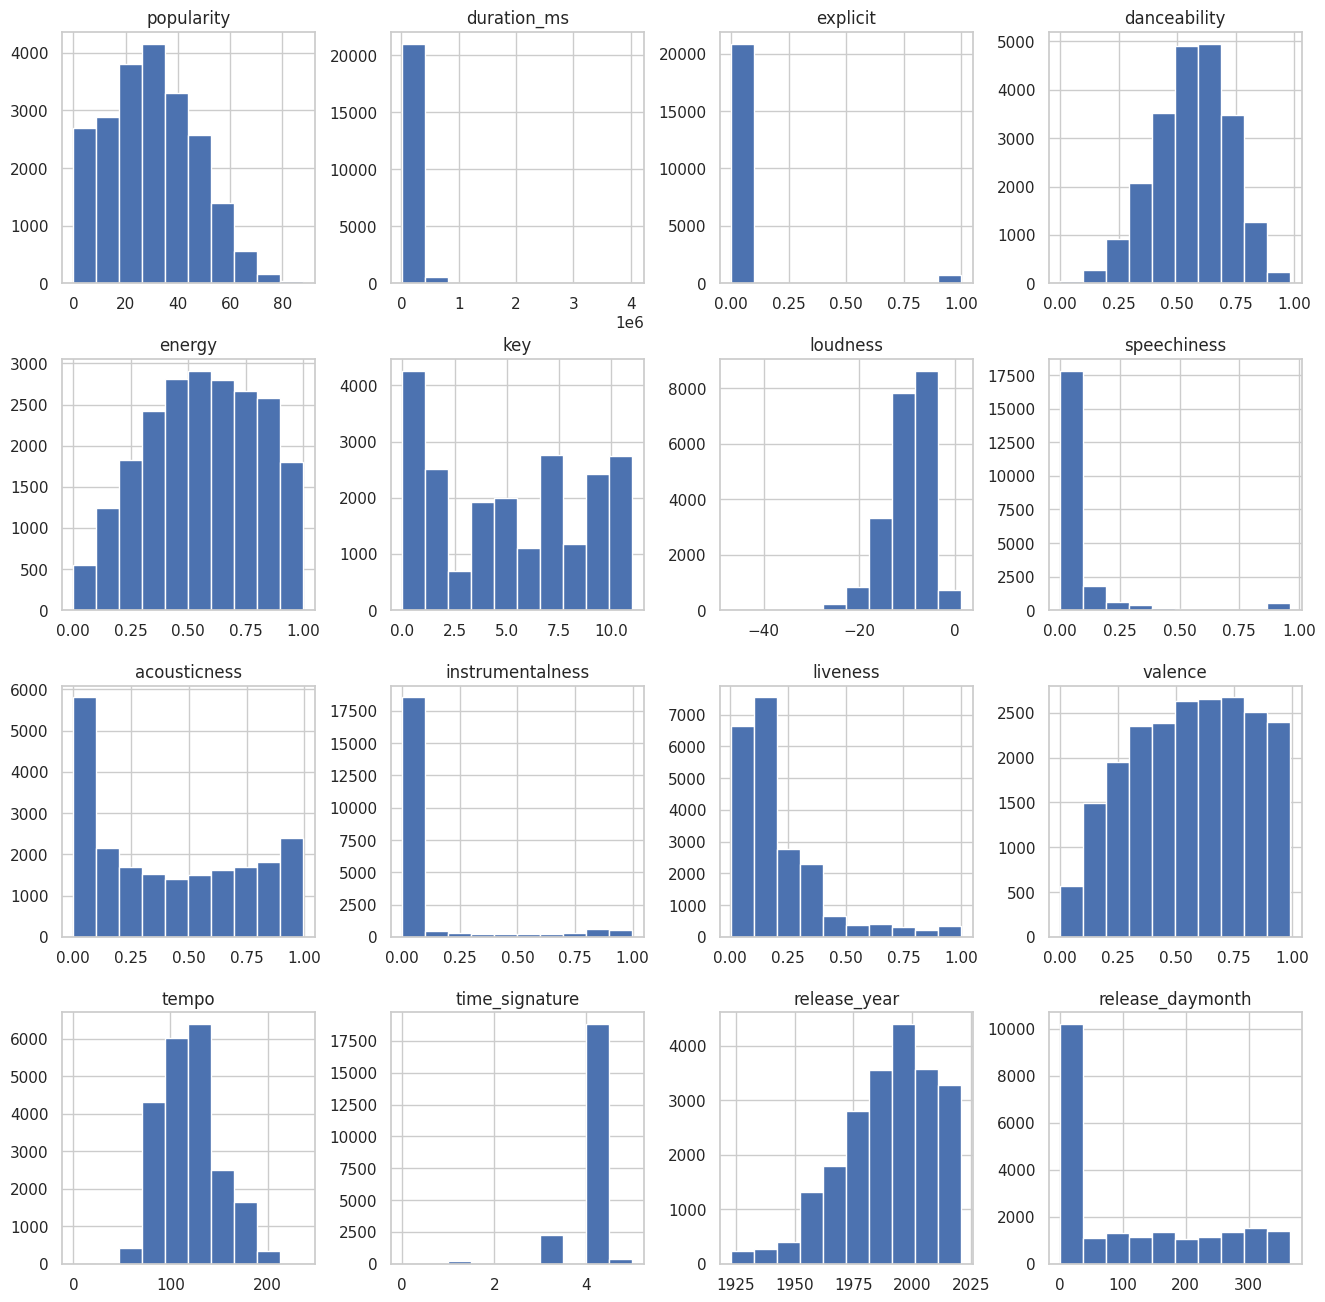

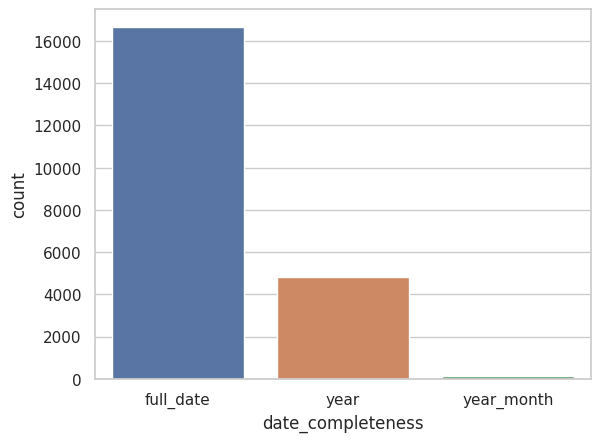

In [207]:
show_basic_info(tracks)

def clear_tracks(df: pd.DataFrame):
    df=df.drop(columns=['mode'])
    df = extract_release_date(df).drop(columns=['release_date'])
    return df

    
df = clear_tracks(tracks)
df.hist(figsize=(16, 16))
fig, ax = plt.subplots()
sns.countplot(df, x='date_completeness')

## Użytkownicy

# rows 50
Columns ['user_id' 'name' 'city' 'street' 'favourite_genres' 'premium_user']
Missing values:  Index([], dtype='object')


<Axes: title={'center': 'Ulubione gatunki użytkowników'}, xlabel='favourite_genres'>

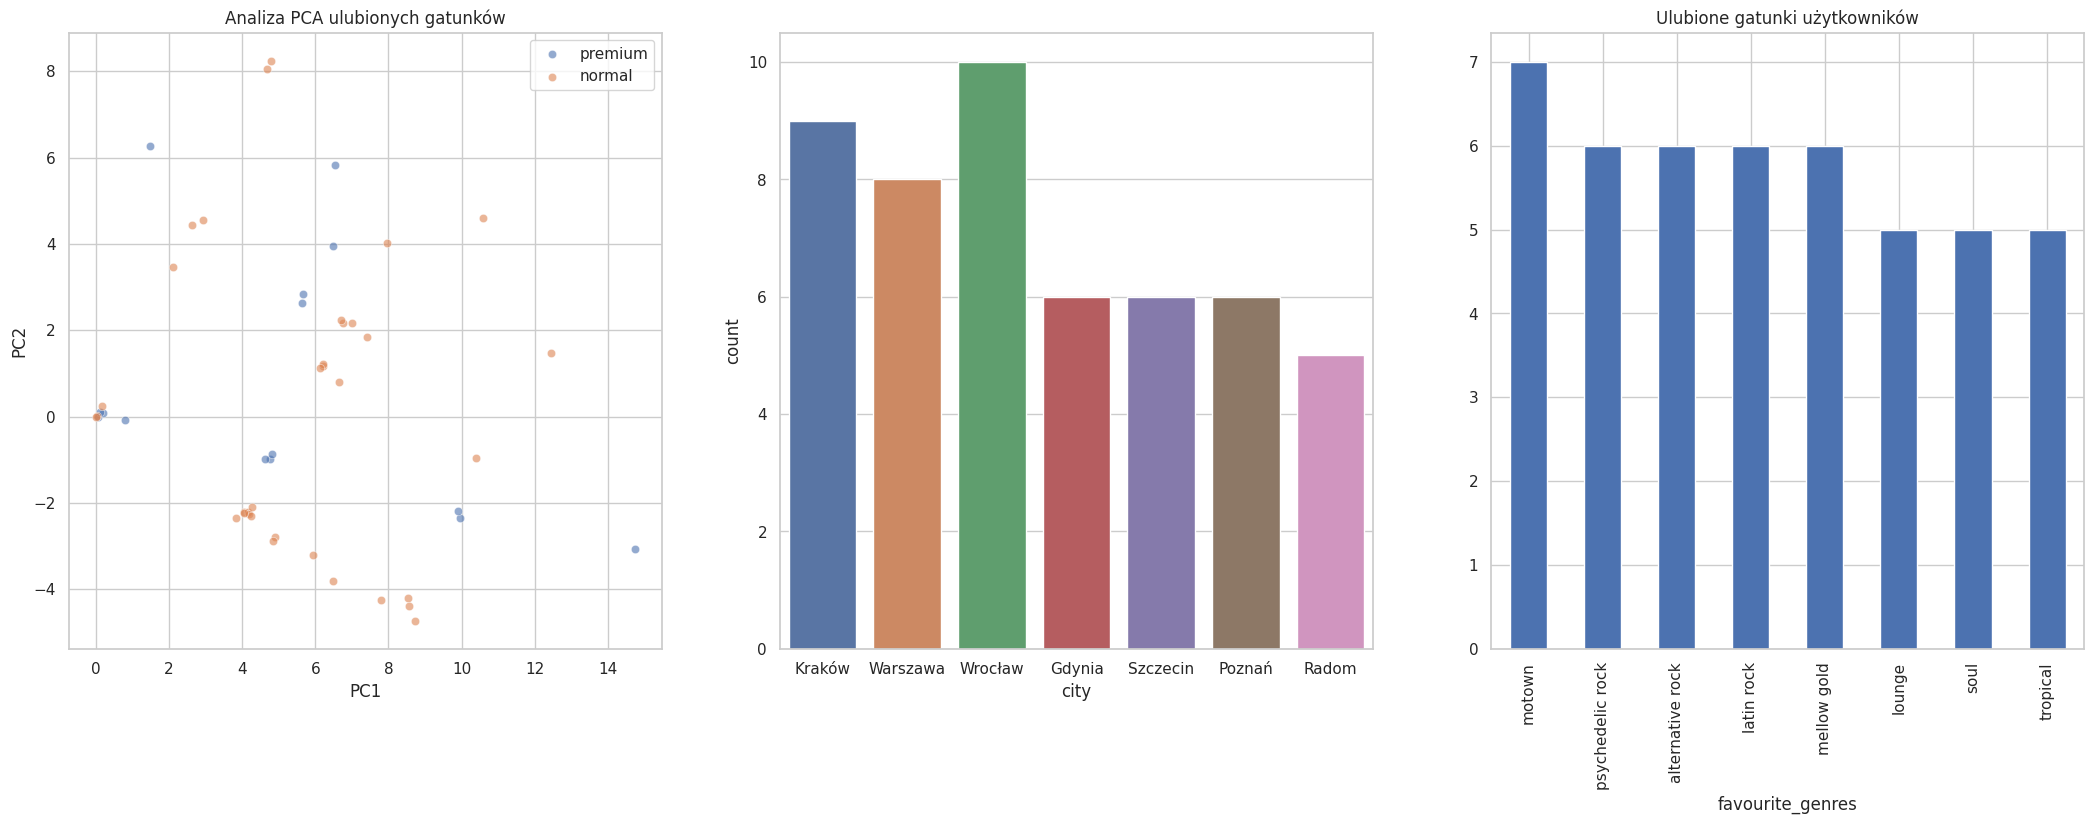

In [205]:
show_basic_info(users)
fig, axs = plt.subplots(1, 3, figsize=(26, 8))
axs[0].set_title("Analiza PCA ulubionych gatunków")
def prepare_pca(fav_genres: pd.Series, label: str):
    svd = TruncatedSVD(n_components=2)
    pca_df = pd.DataFrame(data=svd.fit_transform(vstack(vstack(encode_track(fav_genre) for fav_genre in fav_genres))), columns=['PC1', 'PC2'])
    sns.scatterplot(pca_df, x='PC1', y='PC2', alpha=0.6, label=label, ax=axs[0])
prepare_pca(users[users['premium_user']==True]['favourite_genres'], 'premium')
prepare_pca(users[users['premium_user']==False]['favourite_genres'], 'normal')
sns.countplot(users, x='city', ax=axs[1])
user_fav_genres = users['favourite_genres'].explode()
user_fav_genres.value_counts().where(lambda x: x>4).dropna().astype(int).plot(kind='bar', ax=axs[2], title='Ulubione gatunki użytkowników')

# Analiza informatywnosci

Na potrzebę dalszej analizy stworzymy zbiór *result.csv*, który w przyszłości będzie także wykorzystany (w przystosowanej formie) do wytrenowania modelu docelowego. Zbiór ten, oprócz cech wziętych stricte z dostępnych danych, posiada również specjalnie stworzone atrybuty, np. współczynnik pominięć piosenki *user_skip_rate*, długość trwania sesji *session_duration* czy też *fav_genres_similarity* mówiący o zbieżności pomiędzy ulubionymi gatunkami muzycznymi użytkownika, a tymi w których nagrywa wykonawca danego utworu.

In [223]:
# block is group of consecutive user interactions with song
def transform_block(df: pd.DataFrame):
    
    def define_block_duration(group: pd.DataFrame):
        if 'skip' not in group['event_type'].values:
            return pd.Timedelta(milliseconds=min(group['duration_ms']))
        return max(group['timestamp'])-min(group['timestamp'])
    
    return df.groupby('block_id').agg(
        isskipped=('event_type', lambda x: 'skip' in x.values),
        isliked=('event_type', lambda x: 'like' in x.values),
        timestamp=('timestamp', lambda x: min(x)),
        track_id=('track_id', 'first'),
        user_id=('user_id', 'first'),
        block_duration = ('timestamp', lambda x: define_block_duration(df))
    ).reset_index(drop=True)

def transform_session(session: pd.DataFrame):
    session['block_id'] = (session['track_id'] != session['track_id'].shift()).cumsum()
    session = session.groupby('block_id').apply(transform_block).reset_index(drop=True)
    
    session['session_duration'] = session['block_duration'].cumsum().shift(fill_value=Timedelta(0))
    session['session_skip_count'] = session['isskipped'].cumsum().shift(fill_value=0)
    session['session_like_count'] = session['isliked'].cumsum().shift(fill_value=0)
    session['session_play_count'] = range(len(session))
    
    session['session_skip_rate'] = (session['session_skip_count'] / session['session_play_count']).fillna(0)
    session.replace(np.inf, 0, inplace=True)
    
    session['session_ewma_rate'] = session['isskipped'].astype(int).ewm(alpha=0.8).mean().shift(fill_value=0)

    return session

def transform_user(user: pd.DataFrame):
    user['user_listen_time'] = user['block_duration'].cumsum().shift(fill_value=Timedelta(0))
    user['user_skip_count'] = user['isskipped'].cumsum().shift(fill_value=0)
    user['user_like_count'] = user['isliked'].cumsum().shift(fill_value=0)
    user['user_play_count'] = range(len(user))
    user['user_skip_rate'] = (user['user_skip_count'] / user['user_play_count']).fillna(0)
    user.replace(np.inf, 0, inplace=True)
    user['user_ewma_rate'] = user['isskipped'].astype(int).ewm(alpha=0.8).mean().shift(fill_value=0)
    return user

clean_track = clear_tracks(tracks)
df = sessions[sessions['event_type'].isin(['play', 'skip', 'like'])]
df = df.merge(clean_track[['id', 'duration_ms']].set_index('id'), left_on="track_id", right_on='id')
df = df.groupby('session_id').apply(transform_session).reset_index().drop(columns=['level_1'])

df = df.groupby('user_id').apply(transform_user).reset_index(drop=True)

df = df.join(users.set_index('user_id'), on='user_id', rsuffix="_user").join(genres, on="track_id").join(clean_track.set_index('id'), on="track_id", rsuffix="_track")
df['fav_genres_similarity'] = df.apply(lambda x: genres_similarity(x['genres'], x['favourite_genres']), axis=1)

# df.to_csv("data/result.csv")
target_df=df.drop(columns=[col for col in df.columns if 'id' in col])
target_df

,isskipped,isliked,timestamp,block_duration,session_duration,session_skip_count,session_like_count,session_play_count,session_skip_rate,session_ewma_rate,...,acousticness,instrumentalness,liveness,valence,tempo,time_signature,release_year,release_daymonth,date_completeness,fav_genres_similarity
0,False,True,2023-01-02 05:58:46.000,0 days 00:07:17.813000,0 days 00:00:00,0,0,0,0.000000,0.000000,...,0.544,0.000239,0.6900,0.526,204.945,3,1981,238,full_date,12
1,False,True,2023-01-02 06:06:03.813,0 days 00:01:57.107000,0 days 00:07:17.813000,0,1,1,0.000000,0.000000,...,0.692,0.000000,0.1380,0.394,80.733,4,1980,1,full_date,12
2,False,True,2023-01-02 06:08:00.920,0 days 00:03:44.933000,0 days 00:09:14.920000,0,2,2,0.000000,0.000000,...,0.261,0.000000,0.0734,0.295,162.147,3,1998,1,full_date,8
3,False,True,2023-01-02 06:11:45.853,0 days 00:06:13.970000,0 days 00:12:59.853000,0,3,3,0.000000,0.000000,...,0.261,0.000140,0.0716,0.519,236.799,3,1970,152,full_date,12
4,True,False,2023-01-02 06:17:59.823,0 days 00:01:31.789000,0 days 00:19:13.823000,0,4,4,0.000000,0.000000,...,0.300,0.000330,0.4220,0.765,156.689,4,1979,32,year_month,22
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12359,True,False,2023-10-28 21:39:42.996,0 days 00:00:21.952000,0 days 02:43:03.485000,20,0,28,0.714286,0.040000,...,0.170,0.000000,0.2620,0.707,120.040,4,2017,209,full_date,0
12360,True,False,2023-10-28 20:51:07.988,0 days 00:01:54.734000,0 days 02:43:25.437000,21,0,29,0.724138,0.808000,...,0.430,0.000031,0.1080,0.919,78.990,4,2021,43,full_date,0
12361,True,False,2023-10-28 22:18:04.212,0 days 00:03:10.605000,0 days 02:45:20.171000,22,0,30,0.733333,0.961600,...,0.758,0.000000,0.1610,0.609,100.127,4,2020,177,full_date,0
12362,True,False,2023-10-28 20:48:16.560,0 days 00:02:46.428000,0 days 02:48:30.776000,23,0,31,0.741935,0.992320,...,0.842,0.000007,0.0999,0.124,80.434,4,2021,78,full_date,0


Preprocessing zbioru wynikowego mający na celu przystosowanie go do użycia w trenowaniu modelu. Wykonujemy tu taki czynnpści jak zamianę czasów trwania na sekundy, konwersję typów danych, czy też kodowanie atrybutów dyskretnych.

In [215]:
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
def preprocess_dataset(df: pd.DataFrame):
    final_dataset = df.dropna()
    label_encoder = LabelEncoder()
    final_dataset['city'] = label_encoder.fit_transform(final_dataset['city'])
    
    final_dataset['day']=final_dataset['timestamp'].dt.dayofyear
    final_dataset['hourminute']= final_dataset['timestamp'].dt.hour * 60 + final_dataset['timestamp'].dt.minute
    final_dataset['date_completeness'] = label_encoder.fit_transform(final_dataset['date_completeness'])
    
    final_dataset = final_dataset.drop(columns=['block_duration'])
    final_dataset['session_duration']=final_dataset['session_duration'].apply(lambda x: x.total_seconds())
    final_dataset['user_listen_time']=final_dataset['user_listen_time'].apply(lambda x: x.total_seconds())
    
    final_dataset['premium_user']=final_dataset['premium_user'].astype(int)
    final_dataset['isliked']=final_dataset['isliked'].astype(int)
    final_dataset['isskipped']=final_dataset['isskipped'].astype(int)
    
    # numeric_cols = final_dataset.select_dtypes(include=['float64']).columns
    # scaler = StandardScaler()
    # final_dataset[numeric_cols] = scaler.fit_transform(final_dataset[numeric_cols])
    
    return final_dataset.drop(columns=['timestamp', 'street', 'key', 'time_signature', 'explicit', 'name_track', 'name', 'favourite_genres', 'genres'])
final_dataset = preprocess_dataset(target_df)
final_dataset

,isskipped,isliked,session_duration,session_skip_count,session_like_count,session_play_count,session_skip_rate,session_ewma_rate,user_listen_time,user_skip_count,...,instrumentalness,liveness,valence,tempo,release_year,release_daymonth,date_completeness,fav_genres_similarity,day,hourminute
0,0,1,0.000,0,0,0,0.000000,0.000000,0.000,0,...,0.000239,0.6900,0.526,204.945,1981,238,0,12,2,358
1,0,1,437.813,0,1,1,0.000000,0.000000,437.813,0,...,0.000000,0.1380,0.394,80.733,1980,1,0,12,2,366
2,0,1,554.920,0,2,2,0.000000,0.000000,554.920,0,...,0.000000,0.0734,0.295,162.147,1998,1,0,8,2,368
3,0,1,779.853,0,3,3,0.000000,0.000000,779.853,0,...,0.000140,0.0716,0.519,236.799,1970,152,0,12,2,371
4,1,0,1153.823,0,4,4,0.000000,0.000000,1153.823,0,...,0.000330,0.4220,0.765,156.689,1979,32,2,22,2,377
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
711,0,0,6885.505,12,10,28,0.428571,0.801292,14169.776,23,...,0.779000,0.2740,0.813,130.318,1970,206,0,15,171,1134
712,0,1,7046.972,12,10,29,0.413793,0.160258,14331.243,23,...,0.060100,0.1030,0.361,125.648,1974,1,1,9,171,1139
713,1,0,7558.599,12,11,30,0.400000,0.032052,14842.870,23,...,0.876000,0.1830,0.350,119.976,1986,160,0,15,171,1148
714,1,0,7664.131,13,11,31,0.419355,0.806410,14948.402,24,...,0.000000,0.0458,0.951,89.555,1974,1,1,15,171,1149


Model **Random Forest** umożliwa zbadanie wpływu poszczególnych atrybutów na wynik modelu, czyli ich informatywność. Po wykorzystaniu stworzonego przed chwilą zbióru danych do wytrenowania takiego klasyfikatora (o dokładności osiągającej już na tym etapie 74.7%) dowiadujemy się, że zdecydowanie największe znaczenie ma sztucznie stworzony atrybut *user_skip_rate*. Dokładna informatywnośc każdego z atrybutów jest widoczna na wykresie poniżej.

Accuracy: 0.753740396279822


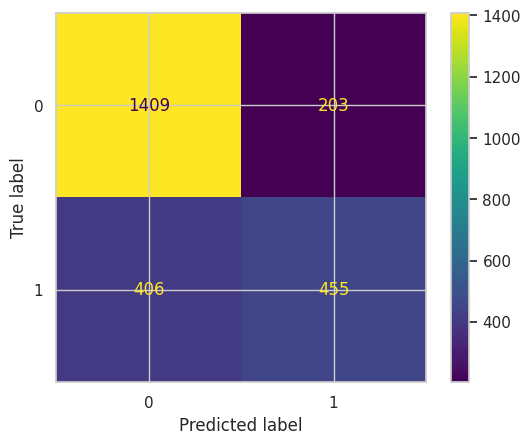

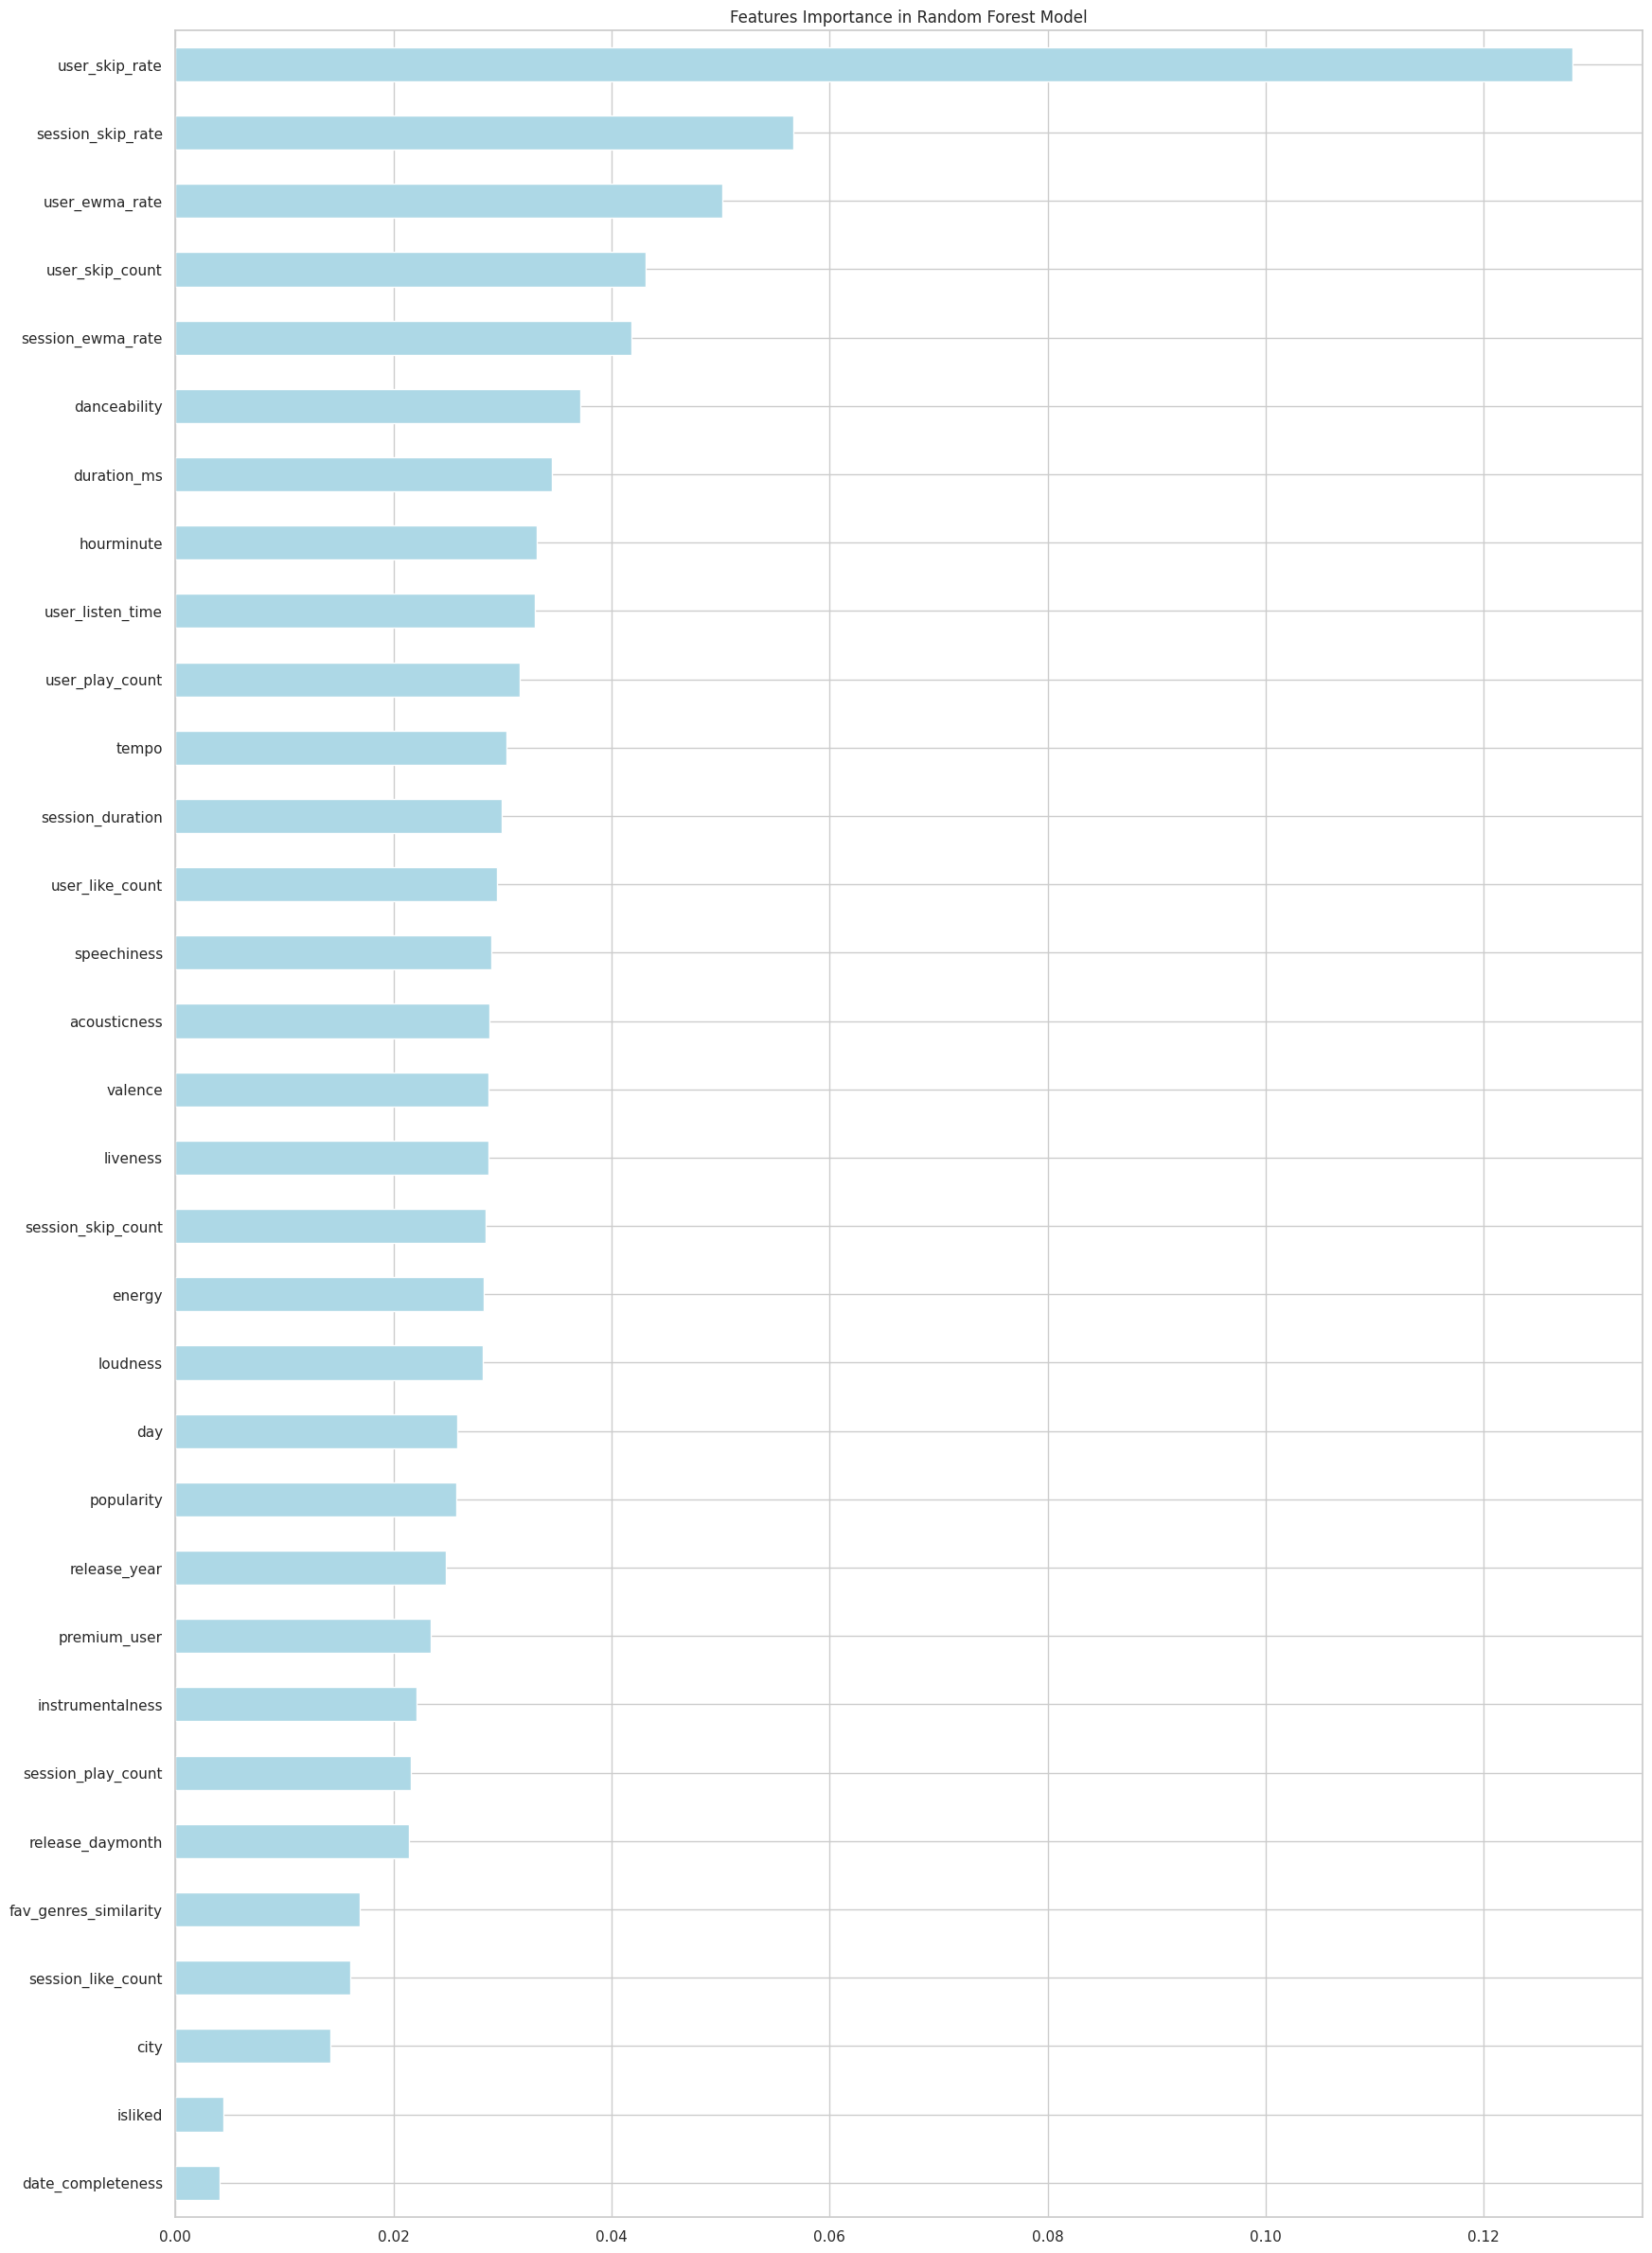

In [225]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix,ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

final_dataset = preprocess_dataset(target_df)
Y = final_dataset['isskipped']
X = final_dataset.drop(columns='isskipped')
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)

clf = RandomForestClassifier(n_estimators=100)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
cm = confusion_matrix(y_test, y_pred, labels=clf.classes_)
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_).plot()

feature_importances = clf.feature_importances_
feature_names = X.columns
importances = pd.Series(feature_importances, index=feature_names)
importances_sorted = importances.sort_values()
plt.figure(figsize=(20,30))
importances_sorted.plot(kind='barh', color='lightblue')
plt.title('Features Importance in Random Forest Model')
plt.show()

# EDA

## Pytania
- informatywność
    - samych danych audio
    - średnia stosunek przewijania piosenek użytkownika/sesji
    - gatunki piosenki i ulubione gatunki uzytkownika
    - popularność piosenki w danym czasie
    - pora dnia, dzień tygodia, miesiąc
    - poprzednia piosenka
    - długość piosenki
    - użytkownik premium
    - stosunek przesłuchania piosenek przez użytkownika
    - polikownaie
- czy przez klastrowanie - ogólne zachowanie użytkownika - stworzy się przydatną zmienną
- czy poprzednia piosenka ma wpływ na zachowanie użytkownika
- czy like,adv ma wpływ na zachowanie użytkownika 

In [62]:


def plot_heat_corr(X: pd.DataFrame, Y: pd.DataFrame, figsize=(24, 9)):
    corr = X.corrwith(Y).to_frame().T
    corr.index = ['isskipped']
    f, ax = plt.subplots(figsize=figsize)
    cmap = sns.diverging_palette(230, 20, as_cmap=True)
    sns.heatmap(corr, cmap=cmap, vmax=.3, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5})
    ax.set_xticklabels(ax.get_xticklabels(), rotation=0)


    
analyze_df = pd.read_csv('data/result.csv', index_col=0, parse_dates=['timestamp'], converters={
    'block_duration': lambda x: pd.to_timedelta(x),
    'session_duration': lambda x: pd.to_timedelta(x),
    'user_listen_time': lambda x: pd.to_timedelta(x),
})
analyze_df

,session_id,isskipped,isliked,timestamp,track_id,user_id,block_duration,session_duration,session_skip_count,session_like_count,...,acousticness,instrumentalness,liveness,valence,tempo,time_signature,release_year,release_daymonth,date_completeness,fav_genres_similarity
0,124,False,True,2023-01-02 05:58:46.000,0jNxo9JcSNcyrYW6AIJhIz,101,0 days 00:07:17.813000,0 days 00:00:00,0,0,...,0.544,0.000239,0.6900,0.526,204.945,3,1981,238,full_date,12
1,124,False,True,2023-01-02 06:06:03.813,3xfmdZVopiPhbqENrH1XOL,101,0 days 00:01:57.107000,0 days 00:07:17.813000,0,1,...,0.692,0.000000,0.1380,0.394,80.733,4,1980,1,full_date,12
2,124,False,True,2023-01-02 06:08:00.920,59m93IlJ9N9dOjAZIm9NzY,101,0 days 00:03:44.933000,0 days 00:09:14.920000,0,2,...,0.261,0.000000,0.0734,0.295,162.147,3,1998,1,full_date,8
3,124,False,True,2023-01-02 06:11:45.853,4FJ0051ukEptZAhP01ExGV,101,0 days 00:06:13.970000,0 days 00:12:59.853000,0,3,...,0.261,0.000140,0.0716,0.519,236.799,3,1970,152,full_date,12
4,124,True,False,2023-01-02 06:17:59.823,4JHoOfnad61lljGlVhfFSb,101,0 days 00:01:31.789000,0 days 00:19:13.823000,0,4,...,0.300,0.000330,0.4220,0.765,156.689,4,1979,32,year_month,22
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12359,820,True,False,2023-10-28 21:39:42.996,5hTpBe8h35rJ67eAWHQsJx,150,0 days 00:00:21.952000,0 days 02:43:03.485000,20,0,...,0.170,0.000000,0.2620,0.707,120.040,4,2017,209,full_date,0
12360,820,True,False,2023-10-28 20:51:07.988,2kFHjWko1il6O9L3eK9IzG,150,0 days 00:01:54.734000,0 days 02:43:25.437000,21,0,...,0.430,0.000031,0.1080,0.919,78.990,4,2021,43,full_date,0
12361,820,True,False,2023-10-28 22:18:04.212,0zlnHTHiBQ68ZCAmTw5ozm,150,0 days 00:03:10.605000,0 days 02:45:20.171000,22,0,...,0.758,0.000000,0.1610,0.609,100.127,4,2020,177,full_date,0
12362,820,True,False,2023-10-28 20:48:16.560,1dBBmAddRRIw6GwF7dPz6z,150,0 days 00:02:46.428000,0 days 02:48:30.776000,23,0,...,0.842,0.000007,0.0999,0.124,80.434,4,2021,78,full_date,0


## Analiza danych audio

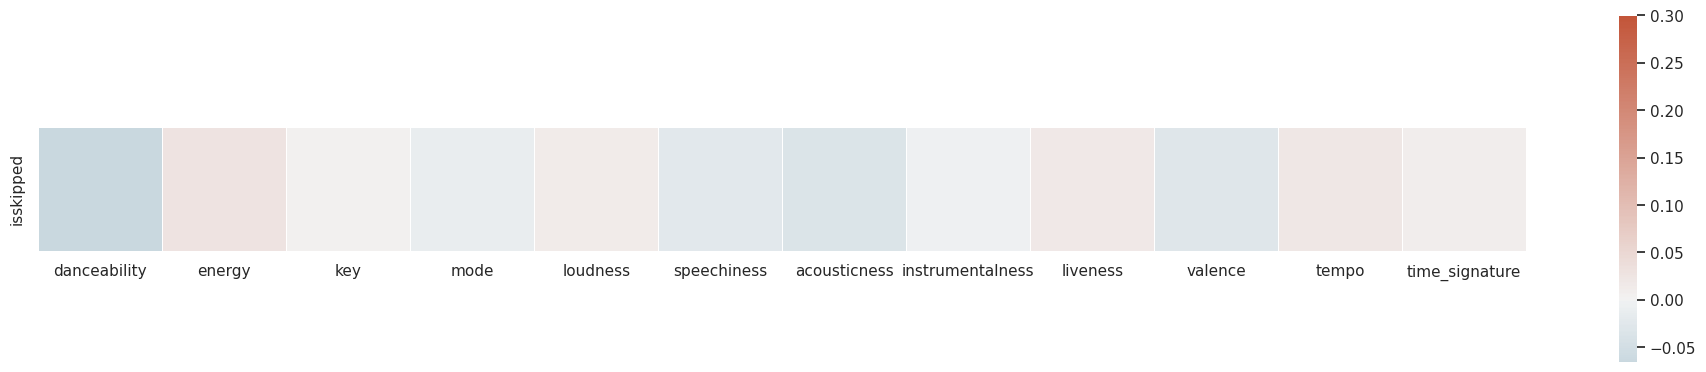

In [231]:

plot_heat_corr(analyze_df.loc[:, 'danceability':'time_signature'], analyze_df['isskipped'])

Explained Variance Ratio: [0.23905733 0.13443676]


<Axes: xlabel='PC1', ylabel='PC2'>

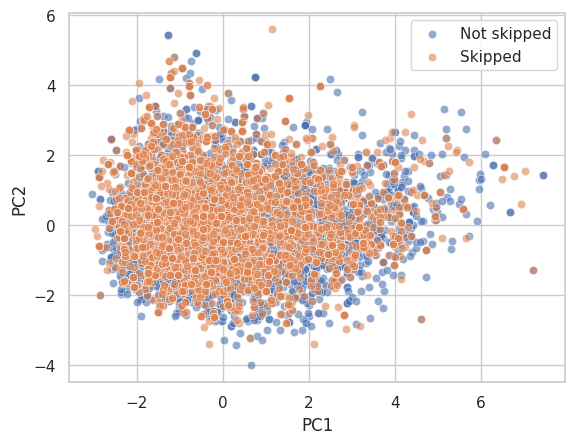

In [232]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
X = analyze_df.loc[:, 'danceability':'time_signature'].drop(columns=['mode']).values
pca = PCA(n_components=2)
principal_components = pca.fit_transform(StandardScaler().fit_transform(X))
pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])
print("Explained Variance Ratio:", pca.explained_variance_ratio_)
df=pd.concat([pca_df, analyze_df['isskipped']],axis=1)
sns.scatterplot(df[df['isskipped']==False], x='PC1', y='PC2', label="Not skipped", alpha=0.6)
sns.scatterplot(df[df['isskipped']==True], x='PC1', y='PC2', label="Skipped", alpha=0.6)

## Analiza wpływu czasu

Sprawdzimy korelację pomiędzy tym kiedy użytkownik słcuha piosenki (dzień tygodnia, miesiąc), a tym czy ją przewinął, czy nie.

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(14, 2))
analyze_df.resample('M', on="timestamp").count()['isskipped'].plot(ax=axs[0], title="Songs played")
analyze_df.resample('M', on="timestamp").agg(skips=('isskipped', 'mean')).plot(ax=axs[1], title="Songs skip rate")

<Axes: xlabel='dayofweek'>

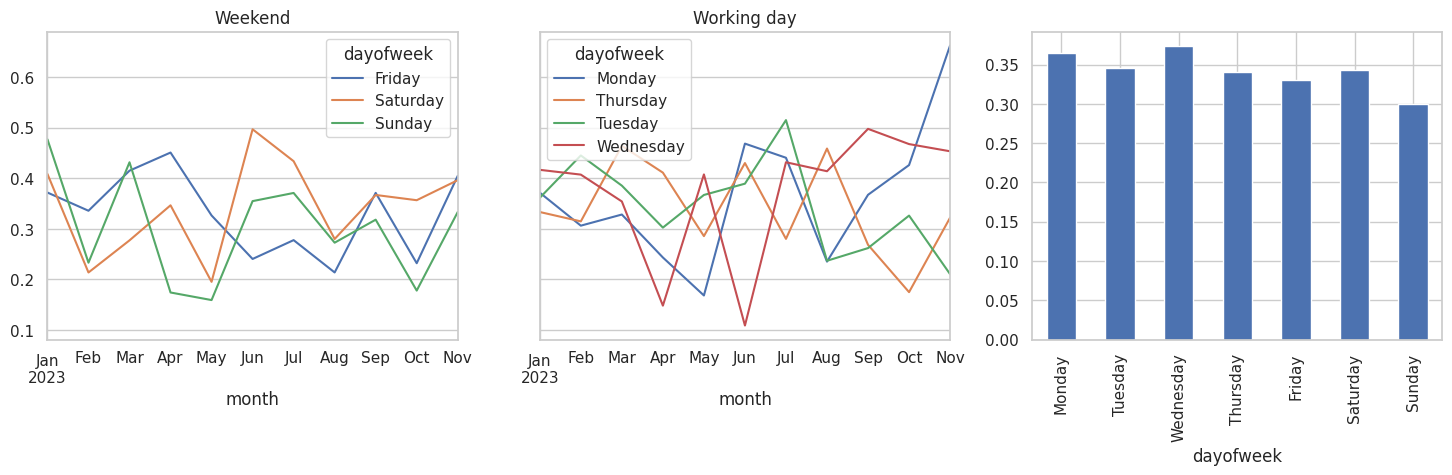

In [233]:
import calendar
fig = plt.figure(figsize=(18, 4))
ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132, sharey=ax1)

weekend = ['Friday', 'Saturday', 'Sunday']
df = analyze_df
df['dayofweek'] = df['timestamp'].dt.dayofweek
df['month'] = df['timestamp'].dt.to_period('M').dt.to_timestamp()
df = df.groupby(['month', 'dayofweek'])['isskipped'].mean().reset_index().pivot_table(index='month', columns='dayofweek', values='isskipped')
df.rename(columns={i: day for i, day in enumerate(calendar.day_name)}, inplace=True)

df[weekend].plot(ax=ax1, title="Weekend")
df[ df.columns.difference(weekend)].plot(ax=ax2, title="Working day")
df.mean(axis=0).plot(kind='bar', ax=fig.add_subplot(133))

- Nie widać znaczącej korelacji pomiędzy czasem, kiedy piosenka została pominięta a pominięciem.

## Analiza wpływu gatunku

Zbadamy to jak ma się gatunek muzyczny piosenki (wydedukowany na bazie tego w jakich gatunkach obraca się wykonawca) oraz ulubione gatunki użytkownika do tego, czy piosenka zostanie przewinięta, czy nie.

In [234]:
# Korelacja pomiędzy podobieństwem piosenki do ulubionych gatunków użytkownika, a przewinięciem
df = analyze_df[['isskipped', 'fav_genres_similarity']]
df.corr()

,isskipped,fav_genres_similarity
isskipped,1.000000,0.068189
fav_genres_similarity,0.068189,1.000000


Jak widać, zastosowanie takiego atrybutu nie niesie za sobą bardzo dużo informacji (intuicyjnie moglibyśmy się spodziewać większej korelacji). Daje to w przyszłości pole manewru to poprawy modelu, np. stosując kodowanie explicite wektora gatunków muzycznych, zamiast budować na ich bazie taki atrybut.

In [235]:
# columns_of_interest = ['session_id', 'id_artist', 'user_id', 'timestamp', 'isskipped', 'genres', 'favourite_genres']
genres_analyze_df = analyze_df
artists_df = artists[artists['id'].isin(genres_analyze_df['id_artist'].values)].set_index('id')[['genres']].map(encode_track)
users_df = users[users['user_id'].isin(genres_analyze_df['user_id'].values)].set_index('user_id')[['favourite_genres']].map(encode_track)
genres_analyze_df=genres_analyze_df.join(artists_df, on='id_artist', rsuffix='_vector').join(users_df, on='user_id', rsuffix='_vector').drop(columns=['genres', 'favourite_genres'])

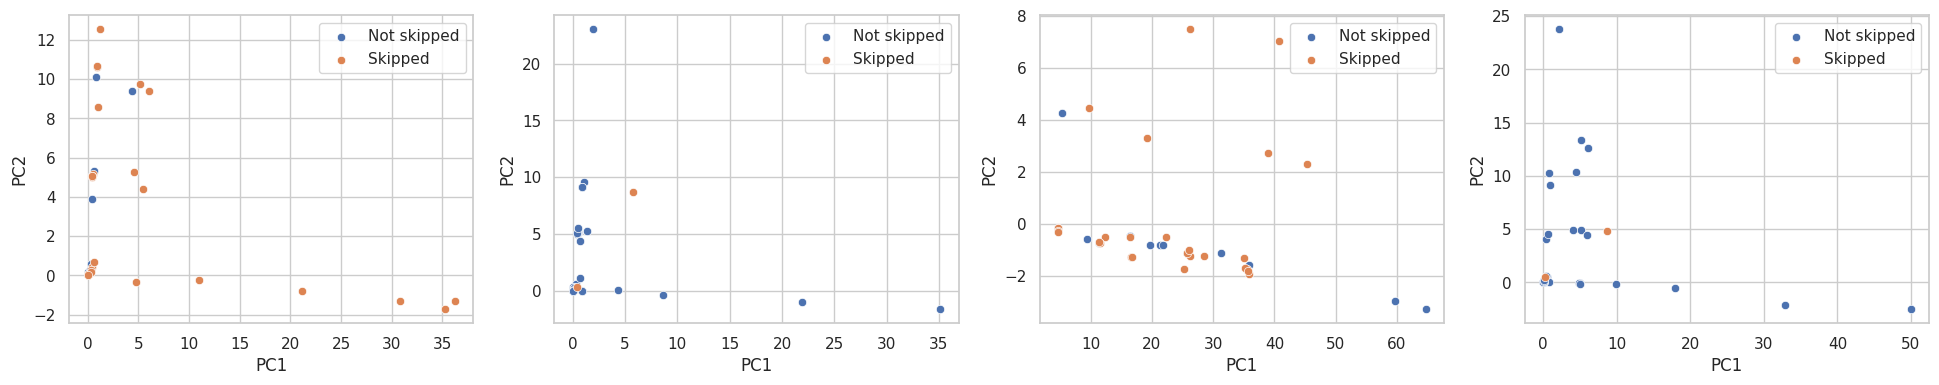

In [236]:
# Choose the longest sessions and different users
idxs = genres_analyze_df.groupby(['session_id', 'user_id'])['session_id'].size().reset_index(name='count').sort_values(['user_id', 'count'], ascending=[True, False]).groupby('user_id').head(1).nlargest(4, 'count')['session_id'].values
columns_of_interest = ['session_id', 'id_artist', 'user_id', 'timestamp', 'isskipped', 'genres', 'favourite_genres']
sessions_df = genres_analyze_df[genres_analyze_df['session_id'].isin(idxs)]
artists_df = artists[artists['id'].isin(sessions_df['id_artist'].values)].set_index('id')[['genres']].map(encode_track)
users_df = users[users['user_id'].isin(sessions_df['user_id'].values)].set_index('user_id')[['favourite_genres']].map(encode_track)
sessions_df=sessions_df.join(artists_df, on='id_artist', rsuffix='_vector').join(users_df, on='user_id', rsuffix='_vector').drop(columns=['genres', 'favourite_genres'])

svd = TruncatedSVD(n_components=2)
pca_df = pd.DataFrame(data=svd.fit_transform(vstack(sessions_df['genres_vector'])), columns=['PC1', 'PC2'])
fdf=pd.concat([pca_df, sessions_df[['isskipped', 'session_id']].reset_index(drop=True)],axis=1)

fig, axs = plt.subplots(1, 4, figsize=(24, 4))
for i, (_, df) in enumerate(fdf.groupby('session_id')):
    sns.scatterplot(df[df['isskipped']==False], x='PC1', y='PC2', label="Not skipped", ax=axs[i])
    sns.scatterplot(df[df['isskipped']==True], x='PC1', y='PC2', label="Skipped", ax=axs[i])

In [237]:

genres_analyze_df['similarity']=genres_analyze_df.apply(lambda x: cosine_similarity(x['genres_vector'], x['favourite_genres_vector'])[0, 0], axis=1)
print(genres_analyze_df[['similarity', 'isskipped']].corr())

def sim(group: pd.DataFrame):
    was_skipped = group[group['isskipped']==True]
    not_skipped = group[group['isskipped']==False]
    if len(was_skipped)<=0 or len(not_skipped) <=0:
        return {
        'skip': None,
        'notskip': None
    }
    a=csr_matrix(vstack(was_skipped['genres_vector']).mean(axis=0))
    c=csr_matrix(vstack(not_skipped['genres_vector']).mean(axis=0))
    b=csr_matrix(vstack(group['favourite_genres_vector']).mean(axis=0))
    return {
        'skip': cosine_similarity(a, b)[0, 0],
        'notskip': cosine_similarity(c, b)[0, 0]
    }
pd.DataFrame([sim(group) for _, group in genres_analyze_df.groupby('session_id')]).dropna().agg(['mean', 'std'])

            similarity  isskipped
similarity      1.0000     0.0287
isskipped       0.0287     1.0000


,skip,notskip
mean,0.479578,0.534078
std,0.335565,0.319727


## Analiza wpływu poprzedniej piosenki

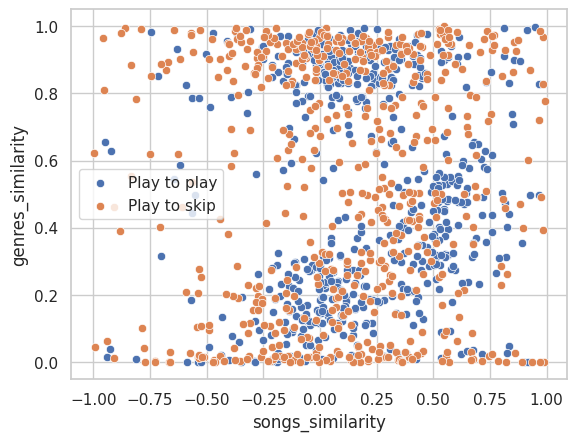

In [243]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

not_musical = ['name', 'mode', 'explicit', 'release_date', 'id_artist']


def song_stats_by_behaviour(behaviour):
    df = pd.DataFrame(analyze_df[['track_id', 'user_id', 'session_id', 'isskipped', 'timestamp', 'id_artist', 'favourite_genres']])
    df['behaviour']=behaviour(df)
    df['previous_song'] = df['track_id'].shift()
    df['previous_artist'] = df['id_artist'].shift()
    df = df[df['behaviour']==True].drop(columns=['behaviour']).dropna()

    tracks_df = tracks[tracks['id'].isin(set(df['track_id'].values).union(set(df['previous_song'].values)))].set_index('id')
    tracks_df = tracks_df.join(tracks_df['release_date'].map(lambda x: x.split('-')[0]), rsuffix='_year').drop(columns=not_musical)
    artists_df=artists[artists['id'].isin(set(df['id_artist'].values).union(set(df['previous_artist'].values)))].set_index('id')[['genres']]
    artists_df=artists_df.map(encode_track)    
    df = df.join(artists_df, on='id_artist').join(artists_df, on='previous_artist', lsuffix='_previous')
    df['fav_vector'] = df['favourite_genres'].map(encode_track)
    df['genres_similarity']=df.apply(lambda x: cosine_similarity(x['genres'], x['genres_previous'])[0, 0], axis=1)
    
    def pca_on_song_attribs(ldf: pd.DataFrame, track_col_name: str, genres_col_name: str):
        curr_df = ldf.join(tracks_df, on=track_col_name)
        curr_df['fav_gen_sim']=curr_df.apply(lambda x: cosine_similarity(x[genres_col_name], x['fav_vector'])[0, 0], axis=1)
        curr_df = curr_df[np.append(tracks_df.columns.values, ['fav_gen_sim'])]
        pca = PCA(n_components=3)
        principal_components = pca.fit_transform(StandardScaler().fit_transform(curr_df))
        ldf[track_col_name+"_pca"]=pd.DataFrame({'principal_component': [principal_components[i, :] for i in range(principal_components.shape[0])]}, index=curr_df.index)
        return ldf
    
    pca_on_song_attribs(df, 'track_id', 'genres')
    pca_on_song_attribs(df, 'previous_song', 'genres_previous')
    df['songs_similarity']=df.apply(lambda x: cosine_similarity(x['track_id_pca'].reshape(1, -1), x['previous_song_pca'].reshape(1, -1))[0, 0], axis=1)
    return df

play_to_skip = lambda ldf: (ldf['isskipped']==True) & (ldf['isskipped']!= ldf['isskipped'].shift(fill_value=False))
skip_to_play = lambda ldf: (ldf['isskipped']==False) & (ldf['isskipped']!= ldf['isskipped'].shift(fill_value=False))
play_to_play = lambda ldf: (ldf['isskipped']==False) & (ldf['isskipped']== ldf['isskipped'].shift(fill_value=False))
skip_to_skip = lambda ldf: (ldf['isskipped']==True) & (ldf['isskipped']== ldf['isskipped'].shift(fill_value=False))

def plot_scatter(df: pd.DataFrame, label: str):
    sns.scatterplot(df.groupby('session_id')[['songs_similarity', 'genres_similarity']].mean().reset_index(drop=True), x='songs_similarity', y='genres_similarity', label=label)
    
plot_scatter(song_stats_by_behaviour(play_to_play), "Play to play")
plot_scatter(song_stats_by_behaviour(play_to_skip), "Play to skip")

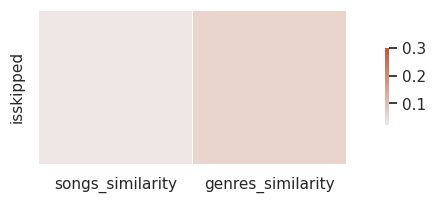

In [244]:
df = song_stats_by_behaviour(lambda x: True)
plot_heat_corr(df[['songs_similarity', 'genres_similarity']], df['isskipped'], figsize=(10, 2))

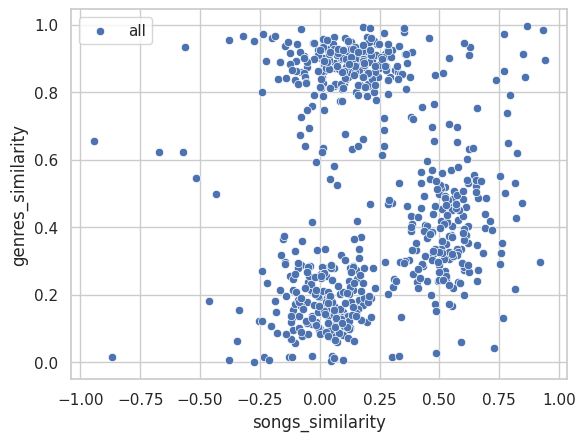

In [245]:
plot_scatter(df, 'all')

## Analiza wpływu zachowania użytkownika w sesji

In [63]:
analyze_df.head()

,session_id,isskipped,isliked,timestamp,track_id,user_id,block_duration,session_duration,session_skip_count,session_like_count,...,acousticness,instrumentalness,liveness,valence,tempo,time_signature,release_year,release_daymonth,date_completeness,fav_genres_similarity
0,124,False,True,2023-01-02 05:58:46.000,0jNxo9JcSNcyrYW6AIJhIz,101,0 days 00:07:17.813000,0 days 00:00:00,0,0,...,0.544,0.000239,0.6900,0.526,204.945,3,1981,238,full_date,12
1,124,False,True,2023-01-02 06:06:03.813,3xfmdZVopiPhbqENrH1XOL,101,0 days 00:01:57.107000,0 days 00:07:17.813000,0,1,...,0.692,0.000000,0.1380,0.394,80.733,4,1980,1,full_date,12
2,124,False,True,2023-01-02 06:08:00.920,59m93IlJ9N9dOjAZIm9NzY,101,0 days 00:03:44.933000,0 days 00:09:14.920000,0,2,...,0.261,0.000000,0.0734,0.295,162.147,3,1998,1,full_date,8
3,124,False,True,2023-01-02 06:11:45.853,4FJ0051ukEptZAhP01ExGV,101,0 days 00:06:13.970000,0 days 00:12:59.853000,0,3,...,0.261,0.000140,0.0716,0.519,236.799,3,1970,152,full_date,12
4,124,True,False,2023-01-02 06:17:59.823,4JHoOfnad61lljGlVhfFSb,101,0 days 00:01:31.789000,0 days 00:19:13.823000,0,4,...,0.300,0.000330,0.4220,0.765,156.689,4,1979,32,year_month,22


<AxesSubplot: >

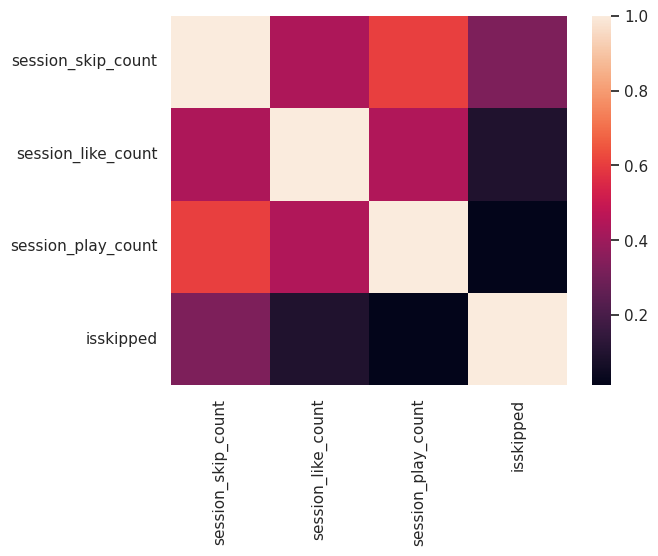

In [65]:
df = analyze_df
# Korelacja pomiędzy poszczególnymi zdarzeniami, które użytkownik może wykonać podczas trwania jego sesji
corr = df[['session_skip_count', 'session_like_count', 'session_play_count', 'isskipped']].corr()
sns.heatmap(corr)

- Zauważalna jest z pewnością zwiększona korelacja pomiędzy *session_skip_count* (liczba pominięć dotychczas w sesji), a skipnięciem kolejnej piosenki.

## Podsumowanie

Z analizy wynika, że dostępne dane umożliwiają stworzenie modelu spełniające analityczne kryterium sukcesu, ponieważ jak wykazuje klasyfikator Random Forest atrybuty niosą za sobą informatywność (w szczególności te atrybuty tworzone sztucznie) i bez dokładnego fine-tuningowania modelu osiągana jest dokładność na poziomie niemal 75%.